In [1]:
import datetime as dt

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import pydotplus

from IPython.display import Image

from scipy.stats import randint as sp_randint

from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import export_graphviz
from sklearn.utils import resample

# Classification (with labels given by the clustering)

## Decision tree

In [2]:
customer_profile = pd.read_csv('datasets/customer_indicators.csv', index_col=0)
customer_clustering = pd.read_csv('datasets/clustering_labels.csv', index_col=0)
customer_clustering = customer_clustering.merge(customer_profile[['CustomerID', 'RFrequency','Max_items']], on='CustomerID')
del customer_profile
customer_clustering

,RMonetary,Delta,Recency,CustomerID,Label,RFrequency,Max_items
0,1.071,2.563,2,12347,High,0.019126,676
1,0.706,2.452,75,12348,Medium,0.014134,1248
2,0.725,2.417,36,12352,Medium,0.026820,125
3,0.914,2.481,23,12356,High,0.009901,1198
4,0.791,2.176,2,12358,Medium,0.013333,144
...,...,...,...,...,...,...,...
3855,1.407,0.000,134,18268,Low,1.000000,2
3856,2.227,0.000,366,18269,Low,1.000000,76
3857,2.240,0.000,74,18278,Low,1.000000,66
3858,2.257,0.000,278,18280,Low,1.000000,45


In [3]:
df_majority = customer_clustering[customer_clustering.Label == 'Medium']
df_minority = customer_clustering[customer_clustering.Label == 'High']
df_middle   = customer_clustering[customer_clustering.Label == 'Low']

customer_clustering.Label.value_counts()

Medium    1698
Low       1250
High       912
Name: Label, dtype: int64

In [4]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority))

# Upsample minority class
df_middle_upsampled = resample(df_middle, 
                               replace=True,     # sample with replacement
                               n_samples=len(df_majority))

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled, df_middle_upsampled])
 
# Display new class counts
customer_clustering = df_upsampled
df_upsampled.Label.value_counts()

Medium    1698
Low       1698
High      1698
Name: Label, dtype: int64

In [5]:
# Function to discretize the variables
# Input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        mapping = {'High': 0, 'Medium': 1, 'Low': 2}

        # Add a new colum with the number representation of the variable
        dataset[variable + '_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [6]:
variables = ['Label']

# Discretize data, in this case only Label
customer_clustering = discretize_data(customer_clustering, variables)

# Drop the categorical variables since we don't need them anymore 
customer_clustering = customer_clustering[['Delta', 'Label_num', 'RFrequency','Max_items']]

label = customer_clustering.pop('Label_num')

scaler = StandardScaler()
customer_clustering = scaler.fit_transform(customer_clustering.values)

train_set, test_set, train_label, test_label = train_test_split(
                                                 customer_clustering, label, stratify=label, test_size=0.3)

## Expected prediction

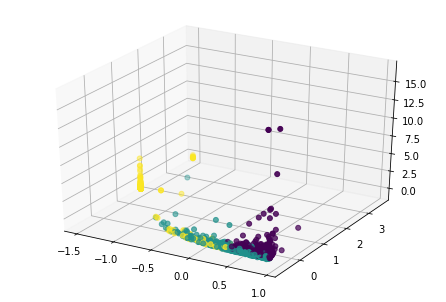

In [7]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(test_set[:, 0], test_set[:, 1], test_set[:, 2], c=test_label.values, s=25)
plt.show()

## Decision Tree

In [8]:
# Decision tree

param_dist = {"max_depth": [2,3,5,6,7,10,12],
              "min_samples_split": sp_randint(20, 30),
              "min_samples_leaf": sp_randint(5, 30),
              "criterion": ["entropy", "gini"],
              "splitter": ["best"]
              }

n_iter_search = 50

dec_t = tree.DecisionTreeClassifier()

grid_search = RandomizedSearchCV(dec_t, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))

grid_search.fit(train_set, train_label)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
       

In [9]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 15, 'min_samples_split': 25, 'splitter': 'best'}
Mean and std of this setting  0.8740532959326789 0.010321665914711977


In [10]:
# Decision tree best setting parameters

dec_t = tree.DecisionTreeClassifier(criterion='entropy', splitter='best',
                                  max_depth=5,
                                  min_samples_split=24, min_samples_leaf=13)

dec_t = dec_t.fit(train_set, train_label)

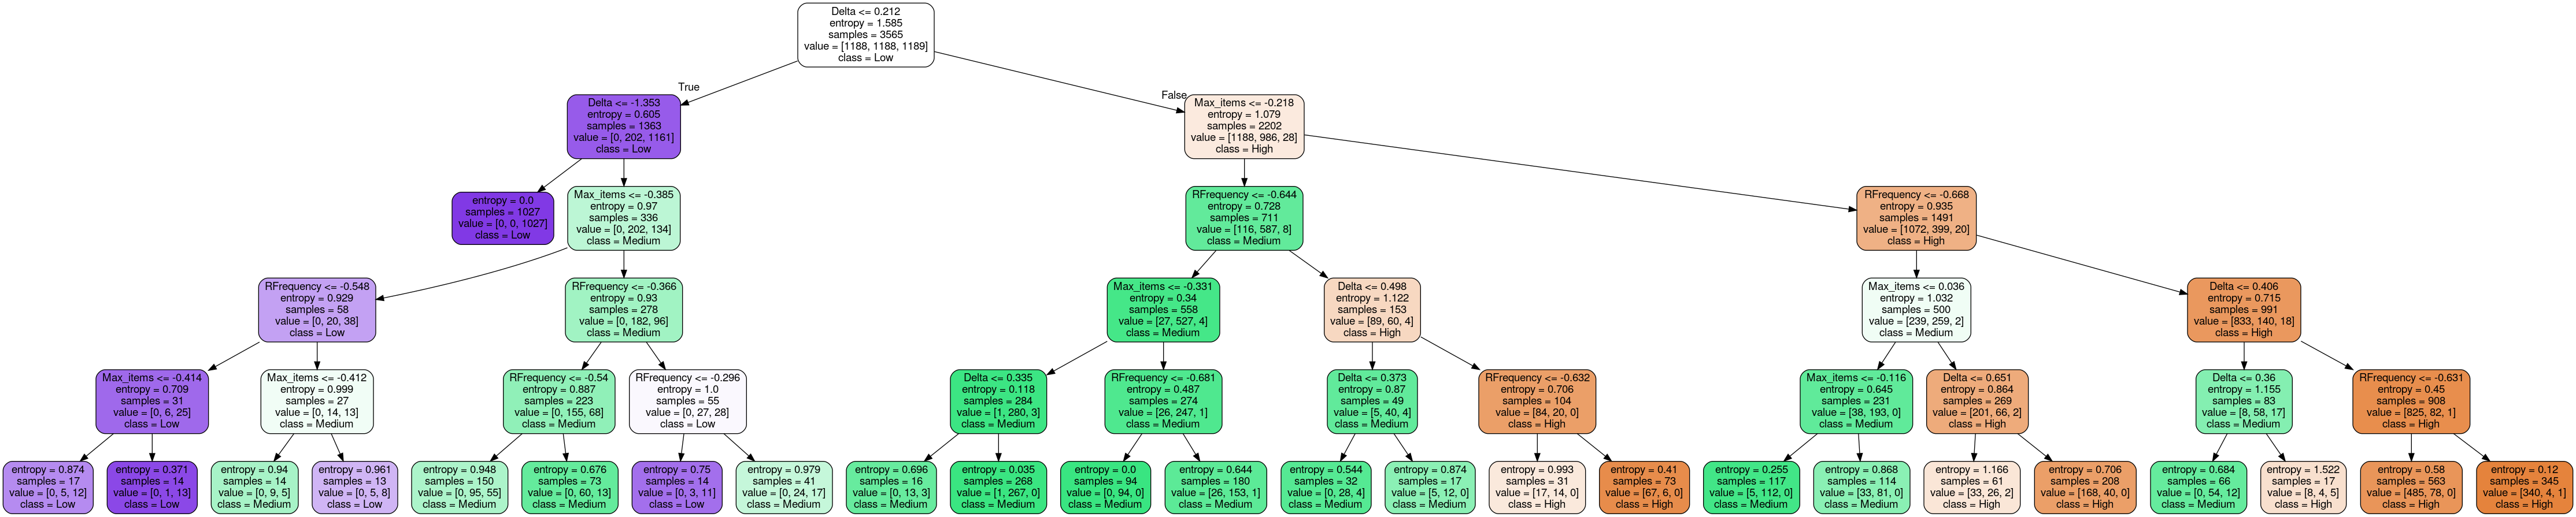

In [11]:
# Show decision tree

dot_data = tree.export_graphviz(dec_t, out_file=None,
                         feature_names=['Delta', 'RFrequency','Max_items'],
                         class_names=['High', 'Medium', 'Low'],
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [12]:
def predict(model, train_set, test_set):
    train_pred = model.predict(train_set)
    test_pred = model.predict(test_set)
    return train_pred, test_pred

In [13]:
# Predict phase

train_pred_dt, test_pred_dt = predict(dec_t, train_set, test_set)

### Evaluation of the decision tree: compute accuracy, precision, recall, confusion matrix

In [14]:
def print_scores(train_label, train_pred, test_label, test_pred, target_names_):
    print('Accuracy train set:', metrics.accuracy_score(train_label, train_pred))
    print('Accuracy test set: ', metrics.accuracy_score(test_label, test_pred))
    print()
    print('F1 score train set:', metrics.f1_score(train_label, train_pred, average='weighted'))
    print('F1 score test set: ', metrics.f1_score(test_label, test_pred, average='weighted'))
    print('Train:')
    print(classification_report(train_label, train_pred, target_names=target_names_))
    print('-' * 53)
    print('Test:')
    print(classification_report(test_label, test_pred, target_names=target_names_))

In [15]:
print_scores(train_label, train_pred_dt, test_label, test_pred_dt, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8950911640953717
Accuracy test set:  0.8770438194898627

F1 score train set: 0.8956659783043743
F1 score test set:  0.8783838002958736
Train:
              precision    recall  f1-score   support

        High       0.86      0.94      0.90      1188
      Medium       0.85      0.84      0.85      1188
         Low       0.99      0.90      0.94      1189

    accuracy                           0.90      3565
   macro avg       0.90      0.90      0.90      3565
weighted avg       0.90      0.90      0.90      3565

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.86      0.90      0.88       510
      Medium       0.80      0.84      0.82       510
         Low       0.98      0.89      0.94       509

    accuracy                           0.88      1529
   macro avg       0.88      0.88      0.88      1529
weighted avg       0.88      0.88      0.88      1529



In [16]:
# compute confusion matrix

from sklearn.metrics import confusion_matrix

print('Train:')
print(confusion_matrix(train_label, train_pred_dt))
print('-' * 18)
print('Test:')
print(confusion_matrix(test_label, test_pred_dt))

Train:
[[1118   70    0]
 [ 172 1002   14]
 [   8  110 1071]]
------------------
Test:
[[458  52   0]
 [ 74 429   7]
 [  3  52 454]]


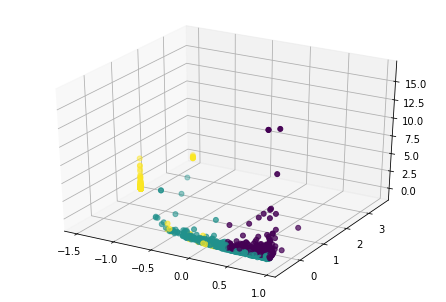

In [17]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(test_set[:, 0], test_set[:, 1], test_set[:, 2], c=test_pred_dt, s=25)
plt.show()

## SVM

In [18]:
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize the output
test_label_binarized = label_binarize(test_label, classes=[0, 1, 2])
train_label_binarized = label_binarize(train_label, classes=[0, 1, 2])

svm =  SVC(kernel='poly', C=0.5, gamma='scale')
svm.fit(train_set, train_label)

svm_binarize = OneVsRestClassifier(SVC(kernel='poly', C=0.5, gamma='scale'))
svm_binarize.fit(train_set, train_label_binarized)

OneVsRestClassifier(estimator=SVC(C=0.5, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='poly', max_iter=-1,
                                  probability=False, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)

In [19]:
# Predictions

train_pred_svm_binarized, test_pred_svm_binarized = predict(svm_binarize, train_set, test_set)

train_pred_svm, test_pred_svm = predict(svm, train_set, test_set)

In [20]:
# Compute the performance of the model

print_scores(train_label, train_pred_svm, test_label, test_pred_svm, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8173913043478261
Accuracy test set:  0.8142576847612819

F1 score train set: 0.8214732422341328
F1 score test set:  0.8178716110814227
Train:
              precision    recall  f1-score   support

        High       0.83      0.73      0.78      1188
      Medium       0.68      0.85      0.76      1188
         Low       1.00      0.87      0.93      1189

    accuracy                           0.82      3565
   macro avg       0.84      0.82      0.82      3565
weighted avg       0.84      0.82      0.82      3565

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.83      0.70      0.76       510
      Medium       0.68      0.86      0.76       510
         Low       1.00      0.88      0.94       509

    accuracy                           0.81      1529
   macro avg       0.83      0.81      0.82      1529
weighted avg       0.83      0.81      0.82      1529



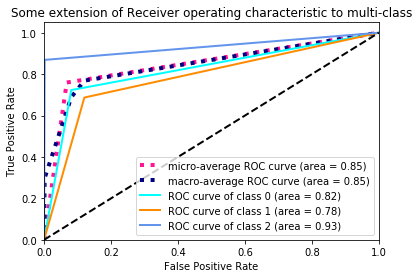

In [21]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

n_classes = 3
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(train_label_binarized[:, i], train_pred_svm_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(train_label_binarized.ravel(), train_pred_svm_binarized.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

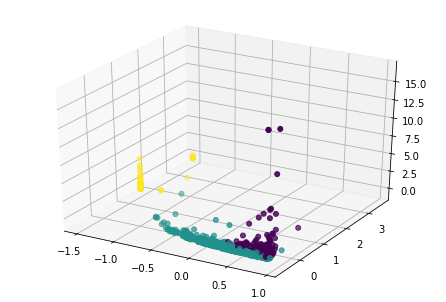

In [22]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(test_set[:, 0], test_set[:, 1], test_set[:, 2], c=test_pred_svm, s=25)
plt.show()

## KNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=4, algorithm='ball_tree', metric='minkowski').fit(train_set, train_label)

In [24]:
#prediction on the test test
train_pred_knn, test_pred_knn = predict(knn, train_set, test_set)

In [25]:
print_scores(train_label, train_pred_knn, test_label, test_pred_knn, ['High', 'Medium', 'Low'])

Accuracy train set: 0.9189340813464235
Accuracy test set:  0.8731196860693263

F1 score train set: 0.9185430999927017
F1 score test set:  0.8722794659947956
Train:
              precision    recall  f1-score   support

        High       0.87      0.98      0.92      1188
      Medium       0.92      0.83      0.87      1188
         Low       0.98      0.94      0.96      1189

    accuracy                           0.92      3565
   macro avg       0.92      0.92      0.92      3565
weighted avg       0.92      0.92      0.92      3565

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.83      0.93      0.88       510
      Medium       0.84      0.76      0.80       510
         Low       0.95      0.93      0.94       509

    accuracy                           0.87      1529
   macro avg       0.87      0.87      0.87      1529
weighted avg       0.87      0.87      0.87      1529



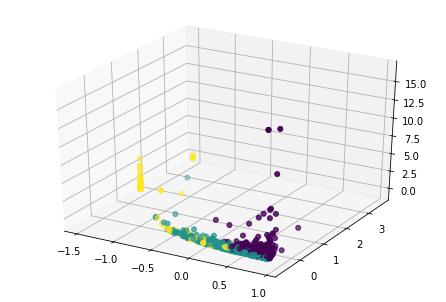

In [26]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(test_set[:, 0], test_set[:, 1], test_set[:, 2], c=test_pred_knn, s=25)
plt.show()

## Classification with Random Forest

In [27]:
# define and fit a random forest
from sklearn.ensemble import RandomForestClassifier

param_dist = {"max_depth": [2, 3, 5, 6, 7, 10, 12, None],
              "max_features": sp_randint(1,len(train_set[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight": ['balanced', None, {0: 0.25, 1: 0.50, 2:0.25}]}

n_iter_search = 50

rf = RandomForestClassifier(n_estimators=30)
grid_search = RandomizedSearchCV(rf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))

grid_search.fit(train_set, train_label)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [28]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': False, 'class_weight': {0: 0.25, 1: 0.5, 2: 0.25}, 'criterion': 'gini', 'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 32, 'min_samples_split': 19}
Mean and std of this setting  0.867882187938289 0.016533141125712632


In [29]:
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=2,
                             class_weight= 'balanced',
                             max_depth=5, 
                             min_samples_split=20,
                             min_samples_leaf=18,
                             bootstrap=False) 

rf = rf.fit(train_set, train_label)

In [30]:
train_pred_rf, test_pred_rf = predict(rf, train_set, test_set)

In [31]:
print_scores(train_label, train_pred_rf, test_label, test_pred_rf, ['High', 'Medium', 'Low'])

Accuracy train set: 0.884992987377279
Accuracy test set:  0.8731196860693263

F1 score train set: 0.8862203944449429
F1 score test set:  0.8747694762834644
Train:
              precision    recall  f1-score   support

        High       0.86      0.92      0.89      1188
      Medium       0.82      0.85      0.83      1188
         Low       0.99      0.88      0.93      1189

    accuracy                           0.88      3565
   macro avg       0.89      0.88      0.89      3565
weighted avg       0.89      0.88      0.89      3565

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.85      0.89      0.87       510
      Medium       0.80      0.84      0.82       510
         Low       0.99      0.89      0.94       509

    accuracy                           0.87      1529
   macro avg       0.88      0.87      0.87      1529
weighted avg       0.88      0.87      0.87      1529



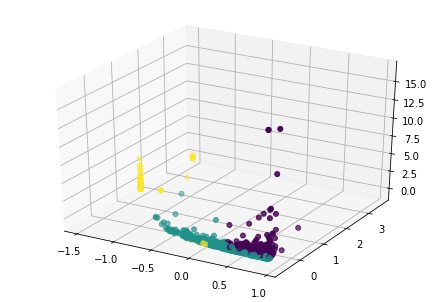

In [32]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(test_set[:, 0], test_set[:, 1], test_set[:, 2], c=test_pred_rf, s=25)
plt.show()

## Neural networks

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.python.keras.utils.np_utils import to_categorical

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(1, len(customer_clustering[0]))))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
train_label_nn = to_categorical(train_label, 3)
test_label_nn = to_categorical(test_label, 3)

In [35]:
history = model.fit(train_set, train_label_nn,
                    epochs=40,
                    batch_size=256,
                    validation_split=0.3)

Epoch 1/40
10/10 [==============================] - 4s 153ms/step - loss: 1.0675 - accuracy: 0.3880 - val_loss: 0.9502 - val_accuracy: 0.6449
Epoch 2/40
10/10 [==============================] - 0s 9ms/step - loss: 0.9593 - accuracy: 0.5655 - val_loss: 0.8458 - val_accuracy: 0.6636
Epoch 3/40
10/10 [==============================] - 0s 9ms/step - loss: 0.8653 - accuracy: 0.6353 - val_loss: 0.7397 - val_accuracy: 0.6785
Epoch 4/40
10/10 [==============================] - 0s 17ms/step - loss: 0.7721 - accuracy: 0.6667 - val_loss: 0.6498 - val_accuracy: 0.7140
Epoch 5/40
10/10 [==============================] - 0s 14ms/step - loss: 0.6977 - accuracy: 0.6914 - val_loss: 0.5861 - val_accuracy: 0.7981
Epoch 6/40
10/10 [==============================] - 0s 9ms/step - loss: 0.6416 - accuracy: 0.6994 - val_loss: 0.5440 - val_accuracy: 0.8336
Epoch 7/40
10/10 [==============================] - 0s 9ms/step - loss: 0.5848 - accuracy: 0.7384 - val_loss: 0.5179 - val_accuracy: 0.8084
Epoch 8/40
10/10

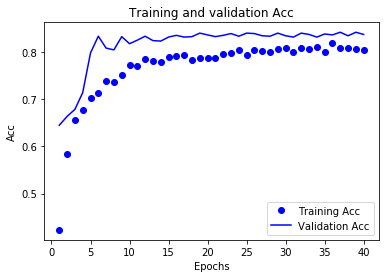

In [36]:
lw = 2
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [37]:
train_pred_nn = np.argmax(model.predict(train_set), axis=-1)
test_pred_nn = np.argmax(model.predict(test_set), axis=-1)

In [38]:
print_scores(train_label, train_pred_nn, test_label, test_pred_nn, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8286115007012623
Accuracy test set:  0.8312622629169392

F1 score train set: 0.831092647747492
F1 score test set:  0.8337731720660093
Train:
              precision    recall  f1-score   support

        High       0.80      0.81      0.81      1188
      Medium       0.73      0.79      0.76      1188
         Low       0.97      0.89      0.93      1189

    accuracy                           0.83      3565
   macro avg       0.84      0.83      0.83      3565
weighted avg       0.84      0.83      0.83      3565

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.81      0.80      0.81       510
      Medium       0.73      0.80      0.76       510
         Low       0.98      0.89      0.93       509

    accuracy                           0.83      1529
   macro avg       0.84      0.83      0.83      1529
weighted avg       0.84      0.83      0.83      1529



## Classification with Naive Bayes

In [39]:
gnb = GaussianNB()
gnb.fit(train_set, train_label)

train_pred_gnb, test_pred_gnb = predict(gnb, train_set, test_set)

In [40]:
print_scores(train_label, train_pred_gnb, test_label, test_pred_gnb, ['High', 'Medium', 'Low'])

Accuracy train set: 0.7685834502103787
Accuracy test set:  0.7913669064748201

F1 score train set: 0.7728153113752954
F1 score test set:  0.7950375688159859
Train:
              precision    recall  f1-score   support

        High       0.74      0.69      0.71      1188
      Medium       0.63      0.74      0.68      1188
         Low       0.97      0.88      0.92      1189

    accuracy                           0.77      3565
   macro avg       0.78      0.77      0.77      3565
weighted avg       0.78      0.77      0.77      3565

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.77      0.71      0.74       510
      Medium       0.66      0.77      0.71       510
         Low       0.98      0.89      0.93       509

    accuracy                           0.79      1529
   macro avg       0.80      0.79      0.80      1529
weighted avg       0.80      0.79      0.80      1529



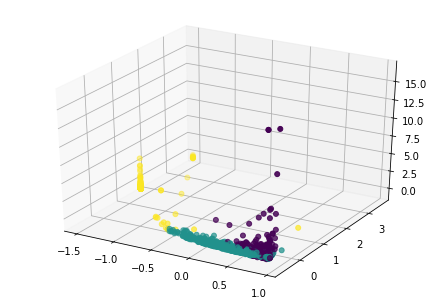

In [41]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(test_set[:, 0], test_set[:, 1], test_set[:, 2], c=test_pred_gnb, s=25)
plt.show()